#### Описание задачи

- Подробное описание в файле gpn-cup-2021-data_science_task.docx

Для увеличения продаж товаров из следующих групп:
- вода
- сладкие газированные напитки, холодный чай
- кофейные напитки с молоком
- энергетические напитки
- снеки
- соки и сокосодержащие напитки  

Вам необходимо разработать рекомендательную систему, которая будет предлагать покупателям 20 дополнительных товаров в чек.  

Пример: покупатель приходит на кассу с 2-мя товарами: напитком «Local-Cola» и чипсами «Sya'l». Алгоритм должен предложить 20 товаров, которые пользователь вероятнее всего захочет добавить в свою корзину (в порядке убывания релевантности). На практике кассир предложит 1й по порядку товар, из имеющихся в наличии. 
В качестве метрики качества рекомендаций используется mean average precision at 20

Транзакционные данные продаж – transactions:
- sku_id – уникальный идентификатор товара
- price – цена, по которой был продан товар
- number – количество товаров (если не топливо) 
- cheque_id – уникальный идентификатор чека
- litrs – количество литров (если товар - топливо)
- client_id – уникальный идентификатор клиента (если клиент «представился» при покупке)
- shop_id – уникальный идентификатор магазина
- date – дата транзакции  

Данные о товарах – nomenclature:
- sku_id – уникальный идентификатор товара
- full_name – полное наименование товара
- brand – наименование торговой марки
- sku_group – группа, к которой принадлежит товар
- OTM – признак собственной торговой марки
- units – единица измерения для количества 
- country – страна производства товара  

Формат всех источников - .parquet.

In [235]:
#! pip install pyarrow

In [881]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import re 
import random

%matplotlib inline

In [785]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Загрузка данных

In [586]:
df_trans = pd.read_parquet("Data/transactions.parquet")

In [298]:
df_nomencl = pd.read_parquet("Data/nomenclature.parquet")

#### Работа с пропусками и типами данных

- Транзакции

In [285]:
df_trans.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002335,0.000000,3338297,0.147929,78634,102,2171-07-23
1,1158,0.002317,0.000000,3386107,0.134562,20900,101,2171-07-23
2,1913,0.007850,0.000452,1845331,0.104183,96397,36,2171-07-23
3,1808,0.008979,0.000452,2256499,0.104183,103560,89,2171-07-23
4,1158,0.002355,0.000000,3257281,0.115023,67691,58,2171-07-23


<br>Пропуски

In [242]:
df_trans.isnull().sum()

sku_id             0
price              0
number             0
cheque_id          0
litrs              0
client_id    3772355
shop_id            0
date               0
dtype: int64

In [587]:
#посмотрю на несколько пропусков
df_trans[df_trans['client_id'].isna()].head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
11,558,0.011237,0.000452,1386544,0.104183,NaN,94,2171-07-23
12,558,0.011237,0.000452,1386544,0.104183,NaN,94,2171-07-23
13,558,0.011237,0.000452,1386544,0.104183,NaN,94,2171-07-23
14,1158,0.002335,0.000000,2582618,0.115122,NaN,103,2171-07-23
16,1158,0.002335,0.000000,3338268,0.126051,NaN,102,2171-07-23


client_id имеет много пропусков, нам об это и сказали в условии задачи (уникальный идентификатор клиента заполнен если клиент "представился" при покупке. под представился вероятно имеется в виду наличие карты лояльности). Заменю таких клиентов на "-1"

In [588]:
df_trans['client_id'] = df_trans['client_id'].fillna(-1)

In [589]:
df_trans.isnull().sum()

sku_id       0
price        0
number       0
cheque_id    0
litrs        0
client_id    0
shop_id      0
date         0
dtype: int64

<br><br>Типы данных

In [590]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620119 entries, 0 to 7620118
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   sku_id     int64         
 1   price      float64       
 2   number     float64       
 3   cheque_id  int64         
 4   litrs      float64       
 5   client_id  float64       
 6   shop_id    int64         
 7   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 465.1 MB


 Все ок, за исключением client_id, почему то у него тип float а по логике должен быть int

In [591]:
#посмотрю на дробные части, есть ли что то отличное от нуля?
client_id_parts = []
for val in df_trans["client_id"].values:
    client_id_parts.append(str(val).split(".")[1])

In [592]:
#дробная часть всегда равна нулю. 
#Переделаю тип в int
set(client_id_parts)

{'0'}

In [593]:
df_trans['client_id'] = df_trans['client_id'].astype(int)

<br><br>Удаление дублей

In [594]:
print("Записей до удаления дубликатов: {}".format(len(df_trans)))

Записей до удаления дубликатов: 7620119


In [595]:
df_trans.drop_duplicates(subset=None, keep='first', inplace=True)

In [596]:
print("Записей после удаления дубликатов: {}".format(len(df_trans)))

Записей после удаления дубликатов: 6800919


<br><br>Поиск выбросов

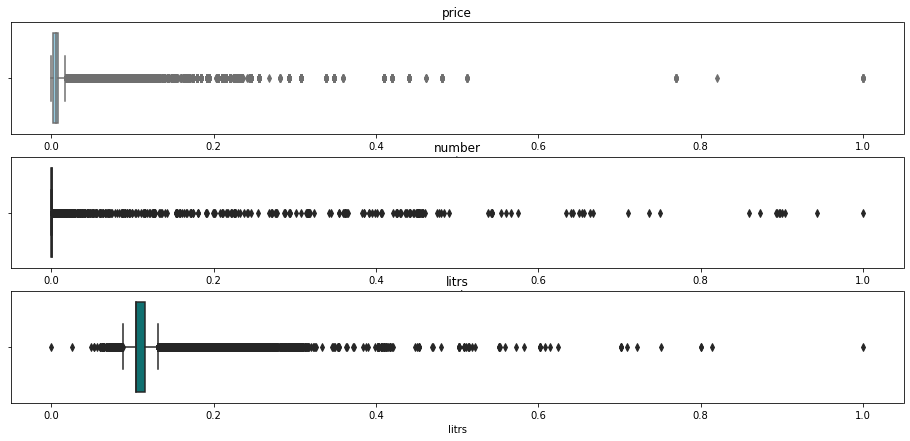

In [597]:
fig, axs = plt.subplots(3, 1, figsize=(16, 7))

axs[0].set_title("price")
axs[1].set_title("number")
axs[2].set_title("litrs")
sns.boxplot(data=df_trans, x="price", color="skyblue", ax=axs[0])
sns.boxplot(data=df_trans, x="number", color="olive", ax=axs[1])
sns.boxplot(data=df_trans, x="litrs", color="teal", ax=axs[2])

plt.show()

Очевидно, что есть выбросы во всех числовых переменных.

- price

Есть цены менше нуля?

In [598]:
df_trans[df_trans["price"] < 0]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date


Посмотрим на товары с высокими ценами

In [599]:
df_trans_top_price = pd.merge(df_trans[df_trans["price"] > 0.4], 
                              df_nomencl,
                              on="sku_id").sort_values(by='cheque_id')

df_trans_top_price.head(5)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
63,4416,0.420215,0.000452,2332,0.104183,399588,5,2171-03-15,Салфетки AURA Antibacterial Derma Protect влаж...,AURA,"Хозяйственные товары, персональный уход",Нет,шт,РОССИЯ
70,4416,0.420215,0.000452,6562,0.104183,23682,68,2171-03-03,Салфетки AURA Antibacterial Derma Protect влаж...,AURA,"Хозяйственные товары, персональный уход",Нет,шт,РОССИЯ
133,4417,0.769112,0.000452,7281,0.104183,354341,68,2171-03-04,Часы Swiss OAK SOW-01 36мм белые,Swiss OAK,"Хозяйственные товары, персональный уход",Нет,шт,КИТАЙ
44,4412,0.481786,0.000452,9396,0.104183,102401,68,2171-03-07,Сумка FlyR TS5 TUBUS универсальная,FlyR,"Хозяйственные товары, персональный уход",Нет,шт,РОССИЯ
65,4416,0.420215,0.000452,13880,0.104183,58143,68,2171-03-13,Салфетки AURA Antibacterial Derma Protect влаж...,AURA,"Хозяйственные товары, персональный уход",Нет,шт,РОССИЯ


In [600]:
df_trans_top_price.tail(5)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
140,4441,0.409954,0.000452,3202878,0.104183,-1,82,2171-03-24,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown
121,4436,0.512571,0.000452,3202954,0.104183,117185,82,2171-03-25,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown
122,4436,0.512571,0.000452,3202987,0.104183,21723,82,2171-03-25,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown
139,4441,0.409954,0.000452,3357581,0.104183,149338,101,2171-03-25,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown
117,4436,0.512571,0.000452,3398337,0.104183,167888,107,2171-04-10,unknown,unknown,"Хозяйственные товары, персональный уход",unknown,unknown,unknown


Очевидно, что салфетки не могут стоить дороже масла, даже в параллельном мире! Тем более что number говорит скорее всего что это цена за 1 упаковку.

In [601]:
df_trans_top_price.head(1)["full_name"].values[0]

'Салфетки AURA Antibacterial Derma Protect влажные спиртовые 15шт'

In [602]:
#посмотрим на другие продажи товара из первой позиции
df_trans[df_trans["sku_id"] == df_trans_top_price.head(1)["sku_id"].values[0]]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
560524,4416,0.420215,0.000452,1884675,0.104183,-1,26,2171-07-20
5068856,4416,0.420215,0.000452,713309,0.104183,287043,42,2171-04-19
5077235,4416,0.420215,0.000452,488697,0.104183,356784,3,2171-04-19
5483087,4416,0.420215,0.000452,641935,0.104183,43649,89,2171-04-11
5570679,4416,0.420215,0.000452,2272740,0.104183,91071,96,2171-04-09
5596189,4416,0.420215,0.000452,33574,0.104183,154931,68,2171-04-09
5614354,4416,0.420215,0.000452,87684,0.104183,-1,14,2171-04-08
5658129,4416,0.420215,0.000452,593569,0.104183,342492,1,2171-04-08
5711413,4416,0.420215,0.000452,484150,0.104183,-1,3,2171-04-06
5758508,4416,0.420215,0.000452,2481805,0.104183,103023,104,2171-04-06


Сколько стоят другие салфетки?

In [603]:
salfetki_skuid = df_nomencl[df_nomencl['full_name'].str.contains("алфетки")].sku_id.values

In [604]:
#группы товаров где есть салфетки
salfetki_sku_group = df_nomencl[df_nomencl['sku_id'].isin(salfetki_skuid)].sku_group.value_counts().index
salfetki_sku_group

Index(['Хозяйственные товары, персональный уход', 'Уход за автомобилем'], dtype='object')

In [605]:
#товары-салфетки из 1 группы
salfetki_skuid_1 = df_nomencl[(df_nomencl['sku_id'].isin(salfetki_skuid)) &
                              (df_nomencl['sku_group'] == salfetki_sku_group[0])].sku_id.values

In [609]:
#товары-салфетки из 2 группы
salfetki_skuid_2 = df_nomencl[(df_nomencl['sku_id'].isin(salfetki_skuid)) &
                              (df_nomencl['sku_group'] == salfetki_sku_group[1])].sku_id.values

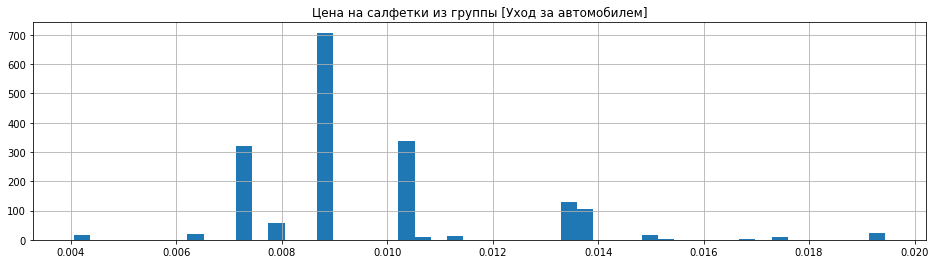

In [625]:
fig, ax = plt.subplots(figsize=(16, 4))

_ = df_trans[df_trans["sku_id"].isin(salfetki_skuid_2)]
_["price"].hist(bins=50, ax=ax)
#ax.set_xticks(np.linspace(0, 0.5, 20));
#ax.set_xlim(0, 0.2);
plt.title("Цена на салфетки из группы [{}]".format(salfetki_sku_group[1]));

In [626]:
_["price"].describe()

count    1777.000000
mean        0.009541
std         0.002474
min         0.004053
25%         0.008671
50%         0.008671
75%         0.010210
max         0.019446
Name: price, dtype: float64

Возможно крайние 2-3 позиции похожи на выбросы, но они не так уж и далеко стоят от 75 перцентиля. Буду считать что это элитные салфетки.

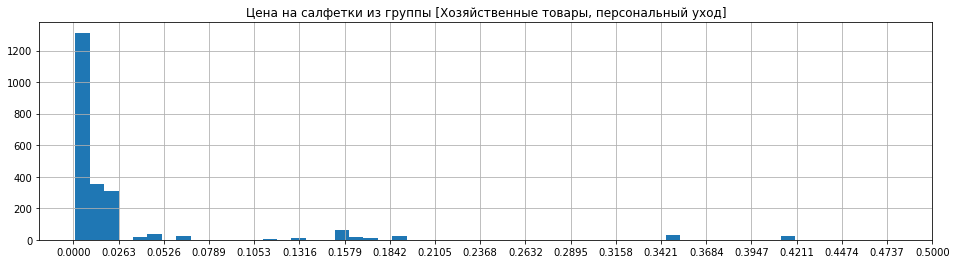

In [627]:
fig, ax = plt.subplots(figsize=(16, 4))

_ = df_trans[df_trans["sku_id"].isin(salfetki_skuid_1)]
_["price"].hist(bins=50, ax=ax)
ax.set_xticks(np.linspace(0, 0.5, 20));
#ax.set_xlim(0, 0.2);
plt.title("Цена на салфетки из группы [{}]".format(salfetki_sku_group[0]));

In [628]:
_["price"].describe()

count    2241.000000
mean        0.027144
std         0.066286
min         0.001231
25%         0.002514
50%         0.008158
75%         0.018214
max         0.420215
Name: price, dtype: float64

Буду считать, что адекватная цена за салфетки в районе 80 перцентиля, остальное это выбросы.  
Выбросы заменю цену на среднее значение после удаления выбросов.

In [635]:
thresh_quantile = 0.80

thresh_quantile_value = _["price"].quantile([thresh_quantile]).values[0]
thresh_quantile_value

0.019240636223704463

In [636]:
price_out_id = _[_["price"] > thresh_quantile_value].index

In [641]:
new_price = _[_["price"] < thresh_quantile_value]["price"].mean()
new_price

0.00628226676810389

In [642]:
df_trans.loc[price_out_id, 'price'] = new_price

Подобные действия нужно проделать для каждой категории товаров.  

!!!Пока пропущу, вернусь сюда позже

- number

Есть количество заказов меньше 0?

In [548]:
df_trans[df_trans["number"] < 0]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date


In [551]:
df_trans_top_number = pd.merge(df_trans[df_trans["number"] > 0.2], 
                              df_nomencl,
                              on="sku_id").sort_values(by='cheque_id')

df_trans_top_number.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
174,3324,0.006619,0.452249,1666636,0.104183,-1,23,2171-05-13,Напиток Fly Cafe молокосодержащий кофейный Флэ...,Fly Cafe,Кофейные напитки с молоком,Да,л,unknown
171,151,0.000051,0.903612,2464176,0.104183,168997,109,2171-03-02,Ароматизатор SAPFIRE SAT-2027 X-Fresh mini кон...,SAPFIRE,Уход за автомобилем,Нет,шт,КИТАЙ
170,151,0.000051,0.226202,2464177,0.104183,89235,109,2171-03-03,Ароматизатор SAPFIRE SAT-2027 X-Fresh mini кон...,SAPFIRE,Уход за автомобилем,Нет,шт,КИТАЙ
168,151,0.000051,0.451363,2464179,0.104183,-1,109,2171-03-03,Ароматизатор SAPFIRE SAT-2027 X-Fresh mini кон...,SAPFIRE,Уход за автомобилем,Нет,шт,КИТАЙ
160,151,0.000051,0.225953,2464194,0.104183,89235,109,2171-03-10,Ароматизатор SAPFIRE SAT-2027 X-Fresh mini кон...,SAPFIRE,Уход за автомобилем,Нет,шт,КИТАЙ


In [553]:
df_trans_top_number['sku_group'].value_counts()

Уход за автомобилем                                      173
Кофейные напитки с молоком                                 1
Гастроном                                                  1
Автохимия и автокосметика (кроме масел, смазок и СОЖ)      1
Вода                                                       1
Name: sku_group, dtype: int64

!!! Разобраться с остальными выбросами

- #### Номенклатура

In [286]:
df_nomencl.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


Типы данных

In [299]:
df_nomencl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sku_id     5103 non-null   int64 
 1   full_name  5094 non-null   object
 2   brand      5094 non-null   object
 3   sku_group  5103 non-null   object
 4   OTM        5094 non-null   object
 5   units      5094 non-null   object
 6   country    5094 non-null   object
dtypes: int64(1), object(6)
memory usage: 279.2+ KB


Все ок с типами данных

<br><br>Такого рода переменные следует удалить. В наших данных такого нет.
- переменных, у которых количество категорий совпадает с количеством наблюдений
- переменных с одним уникальным значением
- переменных констант

<br><br>Пропуски

In [300]:
#где пропуски?
df_nomencl.isnull().sum()

sku_id       0
full_name    9
brand        9
sku_group    0
OTM          9
units        9
country      9
dtype: int64

In [301]:
nan_values_index = [] #сохраню индексы строк с пропусками

for col in df_nomencl.columns:
    nan_values_index = [*nan_values_index, 
                        *df_nomencl[df_nomencl[col].isna()].index.values]
    
nan_values_index = list(set(nan_values_index))

In [302]:
#выделю в отдельный dataframe все строки с пропусками в номенклатуре
df_nomencl_nan = df_nomencl.loc[nan_values_index] #все строки с пропусками

nan_values_sku_id = df_nomencl_nan['sku_id'].values #sku_id товаров с пропусками
nan_values_ethereum_sku_id = df_nomencl_nan[df_nomencl_nan['sku_group'].str.contains('Ethereum')]\
                            ['sku_id'].values#sku_id товаров из тех что имеют пропуски и содержащих *Ethereum*
nan_values_varpfuel_sku_id = df_nomencl_nan[df_nomencl_nan['sku_group'].str.contains('варповое')]\
                            ['sku_id'].values#sku_id товаров из тех что имеют пропуски и содержащих *варповое*

df_nomencl_nan

,sku_id,full_name,brand,sku_group,OTM,units,country
3787,1159,None,None,Ethereum 95,None,None,None
3724,1158,None,None,Ethereum 92,None,None,None
3727,1157,None,None,Ethereum 95 бренд,None,None,None
3728,1163,None,None,Топливо варповое с присадками летнее,None,None,None
3825,1162,None,None,Топливо варповое с присадками зимнее,None,None,None
3858,2032,None,None,Ethereum 100 бренд,None,None,None
4407,1161,None,None,Топливо варповое летнее,None,None,None
4922,1771,None,None,Топливо варповое с присадками межсезонное,None,None,None
3771,1160,None,None,Топливо варповое зимнее,None,None,None


Все 9 столбцоы с пропусками в 9 записях. Отсутствует все кроме наименования. Видно что все товары это топливо. 
Не смотря на то, что в условии задачи нет категорий с топливом для которых нужно предложить следующий товар, может существовать связь между топливом и напитками или другими товарами.  

Буду восстанавливать пропущенные значения.

Очевидно, что эти товары топливо.  
Можно проверить по таблице с транзакциями, товар-топливо это если number=0 а litrs>0

In [303]:
_ = df_trans[df_trans['sku_id'].isin(nan_values_sku_id)]
_.groupby('sku_id').sum()

,price,number,cheque_id,litrs,client_id,shop_id
sku_id,,,,,,
1157,877.417355,0.0,578042455371,46769.789831,47729533231,18136774
1158,1146.372298,0.0,854933391015,64796.547015,64522892857,24827189
1159,1587.875485,0.0,1021811921421,85426.704022,86259547698,30263254
1160,9.511008,0.0,3953669028,557.685280,557405146,239409
1161,0.128321,0.0,173756614,6.378492,5128248,5508
1162,261.420708,0.0,205192365280,15609.847960,14899870947,6090343
1163,416.599816,0.0,216360284261,24803.053550,23775975458,7053639
1771,1.841991,0.0,1079612215,109.060796,109909314,43050
2032,310.983807,0.0,158545472810,15628.749112,14414206198,5351588


Как видно, numbers = 0 а litrs - числа, значит units = 'л'

In [304]:
#проставляю для этих пропусков литры
df_nomencl.at[nan_values_index, 'units'] = 'л'

In [255]:
#возьму конкретного клиента и посомотрю его чеки
#добавлю описание товаров из таблицы с номенклатурой

pd.merge(df_trans[df_trans['client_id'] == 341260], df_nomencl,
         on="sku_id").sort_values(by='date').head(5)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
30,2576,0.012776,0.000452,1704326,0.104183,341260,87,2171-03-17,"Батончик SOJ Marshmallow соленая карамель,моло...",SOJ,Кондитерские изделия,Нет,г,РОССИЯ
9,2032,0.002891,0.000000,1704326,0.163646,341260,87,2171-03-17,None,None,Ethereum 100 бренд,None,л,None
17,120,0.003027,0.000452,1704326,0.104183,341260,87,2171-03-17,Зефир CorNiche Mega Marshmallows пакет 120г,CorNiche,Кондитерские изделия,Нет,г,ФИЛИППИНЫ
29,654,0.025603,0.000452,1704326,0.104183,341260,87,2171-03-17,Жидкость стеклоомывающая УранПРОМEthereum конц...,УранПРОМEthereum,СОЖ,Да,л,РОССИЯ
28,1159,0.002553,0.000000,1706564,0.130441,341260,87,2171-03-23,None,None,Ethereum 95,None,л,None


??? Почему тут литры и numbers одновременно? numbers маленькие?

??? Есть ли где то литры = 0 или меньше 0

- Посмотрю на товары с пропусками и соджержащие слово Ethereum:

In [305]:
df_nomencl[df_nomencl['sku_group'].str.contains('Ethereum')]

,sku_id,full_name,brand,sku_group,OTM,units,country
549,610,Масло GAZPROMNEFT моторное М-8В 1л,GAZPROMNEFT,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,unknown
550,622,Масло GAZPROMNEFT Super 10W-40 1л,GAZPROMNEFT,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,РОССИЯ
551,617,Масло GAZPROMNEFT Super 10W-40 API SG/CD 4л,GAZPROMNEFT,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,РОССИЯ
552,614,Масло GAZPROMNEFT Premium L 10W-40 API SL/CF A...,GAZPROMNEFT,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,РОССИЯ
553,609,Масло G-Energy F Synth 5W-40 1л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ
554,2653,Масло G-Energy F Synth 5W-40 4л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ
555,612,Масло G-Energy S Synth 10W-40 IT 4л,G-Energy,Масла моторные (для Ethereumовых двигателей),Нет,л,ИТАЛИЯ
556,1595,Масло G-Energy F Synth EC 5W-30 1л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ
557,606,Масло G-Energy F Synth 5W-30 A3/B4 4л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ
558,615,Масло G-Energy S Synth 10W-40 IT 1л,G-Energy,"Масла моторные (для Ethereumовых двигателей) ""...",Нет,л,ИТАЛИЯ


Выводы:
- Ethereum = бензин
- Цифра после Ethereum это октановое число и качество бензина
- Слово "бренд" в Ethereum, полагаю означает brand=G-Energy, иначе brand=GAZPROMNEFT
- Есть строка с моторным маслом, где в столбце units стоит unknown, хотя должно быть "л", похоже такие записи так же нужно отнести к пропускам и поработать с ними отдельно

In [306]:
#sku_id товаров из тех что имеют пропуски и содержащих *Ethereum*
nan_values_ethereum_sku_id

array([1159, 1158, 1157, 2032])

In [307]:
#индексы строк бензина с пропусками brand=G-Energy
genergy_ethereum_index =\
            df_nomencl[(df_nomencl['sku_id'].isin(nan_values_ethereum_sku_id)) &
           (df_nomencl['sku_group'].str.contains('бренд'))].index.values

In [308]:
#индексы строк бензина с пропусками brand=GAZPROMNEFT
gpn_ethereum_index =\
             df_nomencl[(df_nomencl['sku_id'].isin(nan_values_ethereum_sku_id)) &
           (~df_nomencl['sku_group'].str.contains('бренд'))].index.values

In [309]:
#проставляю бренд для бензнина с пропусками
df_nomencl.at[genergy_ethereum_index, 'brand'] = 'G-Energy'
df_nomencl.at[gpn_ethereum_index, 'brand'] = 'GAZPROMNEFT'

In [310]:
#проставляю full_name для бензнина с пропусками
for ethereum_sku_id in nan_values_ethereum_sku_id:
    row = df_nomencl[df_nomencl['sku_id']==ethereum_sku_id]
    df_nomencl.at[row.index, 'full_name'] = row['sku_group']

In [311]:
#проставляю бренд для бензнина с пропусками
df_nomencl.at[genergy_ethereum_index, 'brand'] = 'G-Energy'
df_nomencl.at[gpn_ethereum_index, 'brand'] = 'GAZPROMNEFT'

Посмотрю на страны производства брендов:

In [312]:
df_nomencl[df_nomencl['brand'].isin(['GAZPROMNEFT','G-Energy'])].\
            groupby(['brand','country','sku_group'])['country'].count().unstack().fillna(0)

sku_group            Автохимия и автокосметика (кроме масел, смазок и СОЖ)  \
brand       country                                                          
G-Energy    ИТАЛИЯ                                                 4.0       
            РОССИЯ                                                 2.0       
GAZPROMNEFT unknown                                                2.0       
            ИТАЛИЯ                                                 0.0       
            РОССИЯ                                                 0.0       

sku_group            Масла моторные (для Ethereumовых двигателей)  \
brand       country                                                 
G-Energy    ИТАЛИЯ                                            1.0   
            РОССИЯ                                            2.0   
GAZPROMNEFT unknown                                           0.0   
            ИТАЛИЯ                                            0.0   
            РОССИЯ                                            0.0   

sku_group            Масла моторные (для Ethereumовых двигателей) "УранПромEtherium"  \
brand       country                                                                    
G-Energy    ИТАЛИЯ                                                 7.0                 
            РОССИЯ                                                 0.0                 
GAZPROMNEFT unknown                                                2.0                 
            ИТАЛИЯ                                                 0.0                 
            РОССИЯ                                                10.0                 

sku_group            Масла моторные (для варповых двигателей)"УранПромEtherium"  \
brand       country                                                               
G-Energy    ИТАЛИЯ                                                 0.0            
            РОССИЯ                                                 0.0            
GAZPROMNEFT unknown                                                1.0            
            ИТАЛИЯ                                                 0.0            
            РОССИЯ                                                 3.0            

sku_group            Масла прочие "УранПромEtherium"  \
brand       country                                    
G-Energy    ИТАЛИЯ                               0.0   
            РОССИЯ                               0.0   
GAZPROMNEFT unknown                              1.0   
            ИТАЛИЯ                               0.0   
            РОССИЯ                               2.0   

sku_group            Масла трансмиссионные "УранПромEtherium"  \
brand       country                                             
G-Energy    ИТАЛИЯ                                        0.0   
            РОССИЯ                                        0.0   
GAZPROMNEFT unknown                                       1.0   
            ИТАЛИЯ                                        0.0   
            РОССИЯ                                        1.0   

sku_group            Смазки пластичные "УранПромEtherium"  
brand       country                                        
G-Energy    ИТАЛИЯ                                    0.0  
            РОССИЯ                                    0.0  
GAZPROMNEFT unknown                                   0.0  
            ИТАЛИЯ                                    1.0  
            РОССИЯ                                    0.0

- GAZPROMNEFT - производится в основном в России, есть несколько unknown, полагаю что это тоже Россия.  
- G-Energy - больше в Италии.  
Сейчас речь идет про бензин, очень низкая вероятность что его привозят из-за границы, было бы очень дорого, буду считать что для бензина обоих брендов страна производитель будет Россия. Тем более если брать ГПН то это так.


In [313]:
#проставляю страну для бензнина с пропусками
df_nomencl.at[genergy_ethereum_index, 'country'] = 'РОССИЯ'
df_nomencl.at[gpn_ethereum_index, 'country'] = 'РОССИЯ'

- товары с пропусками содержащие "варповое"

In [314]:
df_nomencl[df_nomencl['sku_group'].str.contains('варповое')]

,sku_id,full_name,brand,sku_group,OTM,units,country
3728,1163,None,None,Топливо варповое с присадками летнее,None,л,None
3771,1160,None,None,Топливо варповое зимнее,None,л,None
3825,1162,None,None,Топливо варповое с присадками зимнее,None,л,None
4407,1161,None,None,Топливо варповое летнее,None,л,None
4922,1771,None,None,Топливо варповое с присадками межсезонное,None,л,None


Полагаю что это дизельное топливо, пропишу бренд=GAZPROMNEFT, страна=Россия

In [315]:
nan_values_varpfuel_index = df_nomencl[df_nomencl['sku_id'].isin(nan_values_varpfuel_sku_id)].index.values

In [316]:
#проставляю страну для дизеля с пропусками
df_nomencl.at[nan_values_varpfuel_index, 'country'] = 'РОССИЯ'

In [317]:
#проставляю full_name для бензнина с пропусками
for sku_id in nan_values_varpfuel_sku_id:
    row = df_nomencl[df_nomencl['sku_id'] == sku_id]
    df_nomencl.at[row.index, 'full_name'] = row['sku_group']

In [318]:
#проставляю бренд для бензнина с пропусками
df_nomencl.at[nan_values_varpfuel_index, 'brand'] = 'GAZPROMNEFT'

In [319]:
df_nomencl[df_nomencl['sku_group'].str.contains('варповое')]

,sku_id,full_name,brand,sku_group,OTM,units,country
3728,1163,Топливо варповое с присадками летнее,GAZPROMNEFT,Топливо варповое с присадками летнее,None,л,РОССИЯ
3771,1160,Топливо варповое зимнее,GAZPROMNEFT,Топливо варповое зимнее,None,л,РОССИЯ
3825,1162,Топливо варповое с присадками зимнее,GAZPROMNEFT,Топливо варповое с присадками зимнее,None,л,РОССИЯ
4407,1161,Топливо варповое летнее,GAZPROMNEFT,Топливо варповое летнее,None,л,РОССИЯ
4922,1771,Топливо варповое с присадками межсезонное,GAZPROMNEFT,Топливо варповое с присадками межсезонное,None,л,РОССИЯ


Что с OTM?

In [272]:
df_nomencl['OTM'].value_counts()

Нет        3336
unknown    1370
Да          388
Name: OTM, dtype: int64

Пока выставлю unknown и пропущу этот слобец. В нем много пропусков, да и в целом он не кажется информативным и полезным, возможно не буду его использовать.

In [320]:
#проставляю для этих пропусков литры
df_nomencl.at[nan_values_index, 'OTM'] = 'unknown'

<br><br>Удаление дубликатов

In [323]:
print("Записей до удаления дубликатов: {}".format(len(df_nomencl)))

Записей до удаления дубликатов: 5103


In [324]:
df_nomencl.drop_duplicates(subset=None, keep='first', inplace=True)

In [325]:
print("Записей после удаления дубликатов: {}".format(len(df_nomencl)))

Записей после удаления дубликатов: 5103


<br><br>Обработка редких категорий  

Если существуют редкие категории, то это может означать например что возможна опечатка или категория не из этого набора данных

In [333]:
#категориальные переменные, кроме "full_name"
nomencl_cat_cols = df_nomencl.select_dtypes(include=['object']).columns.to_list()
nomencl_cat_cols.remove("full_name")
nomencl_cat_cols

['brand', 'sku_group', 'OTM', 'units', 'country']

- brand

In [362]:
df_brand = df_nomencl['brand'].value_counts().sort_values(ascending=True).reset_index()
df_brand

,index,brand
0,КИРИЕШКИ,1
1,Сытоедов,1
2,Nerf,1
3,КУЗЯ Лакомкин,1
4,Тройка,1
...,...,...
495,G-Fly (СТМ),129
496,УранПРОМEthereum,130
497,SAPFIRE,159
498,Fly Cafe,255


Много брендов с только одним товаром, посмотрю на них подробнее.

In [402]:
brands_1sku = df_brand[df_brand["brand"] == 1]["index"].values
brands_1sku.sort() #бренды с одним товаром, сортирую по имени чтобы смотреть опечатки
brands_1sku

array(['7D', 'AROMA TOP LINE', 'ASCANIA', 'AVIORA', 'AdBlue', 'Albeni',
       'Always', 'BAIKAL', 'BEERka', 'BIO MAX', 'BIOCOS',
       'Baikal Reserve', 'Barilla', 'Barinoff', 'Blend-a-med',
       'CONFASHON', 'Cafe Creme', 'Clausthaler', 'Colts', 'DOUBLEMINT',
       'Delifrance', 'Dr.Pepper', 'Dunhill', 'EVE', 'Evitest',
       'FIFA-2018', 'FLAMECLUB', 'FORSITE', 'Fazer', 'Filipino Sun',
       "FinSya'lon", 'G-Box', 'GEISHA', 'GEOVITA', 'Gatorade',
       'Greenfield', 'Head&Shoulders', 'Heineken', 'IRN BRU', 'IRONMAN',
       'Laimon orange', 'Lantmannen Unibake', 'Lenco', 'Logic Compact',
       'Lollipops', 'MAXIBON', 'Magic Pet Beads', 'Maltesers',
       'Me to You', 'Medovarus', 'Moon Berry', 'Morning Care',
       'Mountain DEW', 'NOVA Bright', 'Naturella', 'Nerf', 'Nestle',
       'Notpil', 'Ola!', 'Old Spice', 'PAW Patrol', 'POWERADE', 'PRO',
       'Parmalat', 'Paw Patrol', 'Pepero', 'Pocky', 'Premial', 'REGNUM',
       'Ranaplast', 'Redex', 'Rohaus', 'Rondo', 'SPARTA'

Просмотрел визуально, опечаток не увидел.

Вообще сколько покупают товаров этих брендов?

In [375]:
skuid_brands_1sku = df_nomencl[df_nomencl["brand"].isin(brands_1sku)]["sku_id"].values
skuid_brands_1sku #ид товаров с брендом представленным только одним товаром

array([ 118,  424, 1711,  364, 4254, 1455,  949, 1256, 2194,  664, 2010,
       1795, 3101, 3644, 2108,  287, 1055, 1582,   93, 1122, 4647,  435,
         14, 4509, 2835,  857,  152, 2227, 4314,  500,  471, 4634, 4411,
       1396, 3947, 5085, 4163, 3313,   17, 1433,  626, 2796, 1121,   41,
        506,  766, 4285,  963, 2904, 1008, 4961, 4963, 2068, 2463,  535,
       1924,  577, 1094, 4164, 2516, 3528,  958,   87,  452, 4070,   10,
       1892, 3573, 3994,  822, 1593, 3721,    7,  537, 3133, 1943,  399,
       3509, 2449, 1564, 2460, 3192, 2918,  549, 3071, 1936, 2953, 3050,
       1927, 1671, 1247, 2773, 4128, 3722,  519, 4878, 2492, 3128,  125,
       3257, 2386,  178, 4690, 1938,   23,  410, 2301, 1472, 2114, 4909,
       2916, 2939, 3177, 2667, 2164, 4245, 2532, 2149,  597, 3119, 2507,
        542,   59, 2940, 1102, 2848, 2474, 3546, 1132, 1862])

In [393]:
print("Доля покупаемых товаров бренд которых представлен только одним товаром:\
      {:.2f}%".format((len(df_trans[df_trans['sku_id'].isin(skuid_brands_1sku)])/len(df_trans))*100))

Доля покупаемых товаров бренд которых представлен только одним товаром:      3.36%


Не так то часто такие товары покупают, т.е. товары достаточно редкие, "на ценителя", возможно их стоит в дальнейшем исключить из данных для обучения. Нужно будет еще посмотреть в разрезе конкретных заправок, возможно где то это популярный товар.

In [404]:
brands_sku = df_brand[df_brand["brand"] != 1]["index"].values
brands_sku.sort() #бренды с несколькими товарами
#brands_sku

Опечатки в категориях можно поискать с помощью CountVectorizer или word2vec, найдя похожие слова и просмотрев их. Но данных не так много, для экономии времени просмотрел глазами.

c unknown по всем записям будут разбираться позже.

- sku_group

In [406]:
#df_nomencl['sku_group'].value_counts().sort_values(ascending=True).reset_index()

Просмотрел глазами, все ок.

- OTM

In [407]:
df_nomencl['OTM'].value_counts().sort_values(ascending=True).reset_index()

,index,OTM
0,Да,388
1,unknown,1379
2,Нет,3336


 - units

In [408]:
df_nomencl['units'].value_counts().sort_values(ascending=True).reset_index()

,index,units
0,м,3
1,кг,33
2,мл,45
3,л,706
4,г,1182
5,шт,1416
6,unknown,1718


Возможно стоит объединить в одни единицы "мл" и "л" а так же "кг" и "г", подумаю об этом позже.

- country

In [411]:
#df_nomencl['country'].value_counts().sort_values(ascending=True).reset_index()

Все ок

#### Предобработка данных  

!!! Пока пропустил этот раздел вернусь поже

##### Посмотрю подробнее на объекты номенклатуры, особенно на unknown

In [82]:
df_nomencl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sku_id     5103 non-null   int64 
 1   full_name  5103 non-null   object
 2   brand      5103 non-null   object
 3   sku_group  5103 non-null   object
 4   OTM        5103 non-null   object
 5   units      5103 non-null   object
 6   country    5103 non-null   object
dtypes: int64(1), object(6)
memory usage: 279.2+ KB


In [87]:
df_nomencl.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


##### Начну с групп и объектов групп.

In [88]:
df_nomencl.sku_group.value_counts()

Кондитерские изделия                                               714
Сезонные товары                                                    649
Автотовары                                                         516
Общественное питание                                               441
Уход за автомобилем                                                426
Хозяйственные товары, персональный уход                            423
Снеки                                                              360
Табачные изделия                                                   264
Гастроном                                                          196
Сладкие Уранированные напитки, холодный чай                        184
Соки и сокосодержащие напитки                                      145
Вода                                                               144
Прочие напитки кафе                                                144
Бакалея                                                             95
Очки д

Визуально ошибок в наименовании категорий нет, а значит и нет одинаковых категорий но с разными наименованиями, маппить нечего. Возможно стоит выделить укрупненные категории, типо масла, топливо, еда и напитки и т.д. Пока оставлю как заметку, вернусь к этому позже. 

Посмотрю на каждую категорию товаров отдельно, на пропуски и текущие значения.

- Кондитерские изделия

In [111]:
df_nomencl[df_nomencl.sku_group == 'Кондитерские изделия'].full_name.value_counts()

unknown                                                          151
Круассан 2WEEKS миди сгущенка 3+1 260г                             1
Печенье BombBar протеиновое клубника 60г                           1
Вафли Джумка мягкая карамель,воздушная кукуруза 37г                1
Печенье BombBar протеиновое шоколадный брауни 40г                  1
                                                                ... 
Конфеты Warner Hudson ассорти ликер 150г                           1
Набор DOVE Promises ассорти молочный шоколад коробка 118г          1
Зерно Fly Cafe (СТМ)/G-Fly кофейное черный шоколад 25г             1
Цукаты Fly Cafe (СТМ)/G-Fly апельсиновая корочка шоколад 100г      1
Круассан 2WEEKS мини какао 300г                                    1
Name: full_name, Length: 564, dtype: int64

- unknown по стране можно устранить через бренд
- unknown по бренду можно восстановить по наименованию товаров
- unknown по units можно восстановить по наименованию товаров

Начну с бренда.

In [146]:
#именования товаров у которых не прописан бренд
full_names_without_brand = \
        df_nomencl[(df_nomencl.sku_group == 'Кондитерские изделия') &
                   (df_nomencl.brand == 'unknown') &
                   (df_nomencl.full_name != 'unknown')
                  ].full_name.values

Посмотрим на печенье, есть ли с похожими названиями и проcтавленным брендом.

In [147]:
full_names_without_brand[1]

'Печенье Веселые грибочки 50/45г'

In [117]:
#Посмотрим на товары содержащие слово "Веселые"
df_nomencl[df_nomencl.full_name.str.contains("еселые")]

,sku_id,full_name,brand,sku_group,OTM,units,country
193,1134,Печенье Веселые грибочки 50/45г,unknown,Кондитерские изделия,Нет,г,unknown
3359,2220,Раскраска Voicebook 46001 альбомная Веселые ка...,Voicebook,Сезонные товары,Нет,шт,РОССИЯ
3360,4141,Раскраска Voicebook 46002 альбомная Веселые ка...,Voicebook,Сезонные товары,Нет,шт,РОССИЯ


In [115]:
#Посмотрим на товары содержащие слово "печенье"
df_nomencl[df_nomencl.full_name.str.contains("еченье")]

,sku_id,full_name,brand,sku_group,OTM,units,country
53,798,Печенье ЯШКИНО сдобное клубника 137г,ЯШКИНО,Кондитерские изделия,Нет,г,РОССИЯ
54,4056,Печенье ЯШКИНО сдобное вишня 137г,ЯШКИНО,Кондитерские изделия,Нет,г,РОССИЯ
100,3145,Печенье Любятово Мария традиционное 180г,Любятово,Кондитерские изделия,Нет,г,unknown
156,981,Печенье Юбилейное сахарное традиционное 126/112г,Юбилейное,Кондитерские изделия,Нет,unknown,unknown
193,1134,Печенье Веселые грибочки 50/45г,unknown,Кондитерские изделия,Нет,г,unknown
...,...,...,...,...,...,...,...
3464,1132,Печенье Pocky палочки в шоколаде 42г,Pocky,Кондитерские изделия,Нет,г,"КОРЕЯ, РЕСПУБЛИКА"
3568,2896,Печенье Choco Boy черная смородина 45г,Choco Boy,Кондитерские изделия,Нет,г,unknown
3591,557,Печенье Любятово Мария традиционное 156г,Любятово,Кондитерские изделия,Нет,г,РОССИЯ
3704,1076,"Печенье FOODCODE Кантуччини дикая клюква,минда...",unknown,Кондитерские изделия,Нет,г,РОССИЯ


Похоже, что второе слово в наименовании это и есть бренд, хотя бренд Choco Boy состоит из 2х слов, ВкусныйМир не разделен пробелом. По крайней мере бренд начинается от второго слова. 

Гипотеза1: если второе слово в наименовании на кириллице то бренд состоит из одного этого слова.  

Посмотрим есть ли еще бренды состоящие из 2х слов.

In [148]:
brand_names_kond = [] #бренды кондитерских изделий
brand_names_kond_two_words = [] #бренды, состоящие из 2х слов

brand_names_kond = df_nomencl[df_nomencl.sku_group == 'Кондитерские изделия']\
                                         .brand.value_counts().index

for brand_name_k in brand_names_kond:
    if len(brand_name_k.split(" ")) > 1:
        brand_names_kond_two_words.append(brand_name_k)

In [149]:
re_rus = re.compile("[а-яА-Я]+")
rus_brand = [w for w in filter(re_rus.match, brand_names_kond_two_words)]

In [150]:
rus_brand

['медвежонок Барни',
 'Сладкая Сказка',
 'Капля радуги',
 'Бабушкина смоква',
 'АЗОВСКАЯ Кондитерская Фабрика',
 'Стильные штучки',
 'ВКУСЫ МИРА',
 'Частная галерея',
 'Русский марципан',
 'БОН ПАРИ',
 'Хлебный Спас']

  
Гипотеза1 отвергнута.   

Буду действовать по такому алгоритму при заполнении unknown у бренда:  
- беру товар у которого бренд unknown
- ищу по второму слову похожие товары
- если у похожего товара прописан бренд - беру его
- если у похожего товара нет бренда, значит текущий товар с уникальным брендом, по сути не сильно важно что там прописать, главное что он уникальный, буду брать второе слово как бренд

In [231]:
ids_with_new_brand = [] #сюда буду записывать ид строк для которых заменю бренд

for full_name_wb in full_names_without_brand:
    second_word = full_name_wb.split(" ")[1] #беру второе слово из наименования
    new_brand = second_word #предварительно сохраняю новое имя бренда
    second_word = second_word[1:] #удаляю первый символ, чтобы не переводить весь датафраме в lower
    #все товары содержащие second_word
    skus_with_second_word = df_nomencl[(df_nomencl.sku_group == 'Кондитерские изделия') &
                                        (df_nomencl.full_name.str.contains(second_word))]
    brands = skus_with_second_word['brand'].value_counts().index #наименования брендов
    #если больше 1 бренда
    if len(brands) > 1:
        #удаляю unknown
        brands = [x for x in brands if x != 'unknown']
        #на случай если больше 2х брендов, беру самый популярный
        new_brand = brands[0]
    #прописываю новый бренд для товаров без бренда с именем full_name_wb
    full_name_wb_id = list(df_nomencl[df_nomencl.full_name == full_name_wb].index)
    df_nomencl.at[full_name_wb_id, 'brand'] = new_brand
    ids_with_new_brand = ids_with_new_brand + full_name_wb_id

In [233]:
df_nomencl.loc[ids_with_new_brand].head(15)

,sku_id,full_name,brand,sku_group,OTM,units,country
101,781,Пряник Тульский вареная сгущенка 140г,Тульский,Кондитерские изделия,Нет,г,РОССИЯ
193,1134,Печенье Веселые грибочки 50/45г,Веселые,Кондитерские изделия,Нет,г,unknown
205,226,Пряник Тульский начинка фруктовая 140г,Тульский,Кондитерские изделия,Нет,г,РОССИЯ
415,2574,Набор конфет Celebrations бутылка 312г,СЧАСТЬЕ,Кондитерские изделия,Нет,г,РОССИЯ
698,57,Сладости Zentis марципановая буханка 100г,Zentis,Кондитерские изделия,Нет,г,unknown
887,1527,Конфеты Warner Hudson ассорти ликер 150г,Warner,Кондитерские изделия,Нет,г,ГЕРМАНИЯ
1318,173,Банан Banana Republic сушеный шоколадная глазу...,Banana,Кондитерские изделия,Нет,г,РОССИЯ
1352,4222,"Резинка жевательная Marukawa виноград 5,4г",Orbit,Кондитерские изделия,Нет,г,unknown
1353,2101,"Резинка жевательная Marukawa дыня 5,4г",Orbit,Кондитерские изделия,Нет,г,unknown
1354,1954,"Резинка жевательная Marukawa апельсин 5,4г",Orbit,Кондитерские изделия,Нет,г,unknown


- На сколько корректно проставился Orbit?  
- Набор конфет Celebrations бутылка 312г не корректно прописал бренд, с латинскими словами нужно отдельно поработать  

Гипотеза2: если есть слово в наименовании на латинице то бренд состоит из всех латинских слов.

In [142]:
re_eng = re.compile("[a-zA-Z]+")
eng_brand = [w for w in filter(re_eng.match, brand_names_kond_two_words)]

In [144]:
eng_brand

['Ritter SPORT',
 'Chupa Chups',
 'Fly Cafe (СТМ)',
 'Alpen Gold',
 "Wrigley's 5",
 'tic tac',
 'Nature’s own factory',
 'Candy Lane',
 'Juicy Fruit',
 'Love is...',
 'Choco Boy',
 'Baker House',
 'G-Fly (СТМ)',
 "Wrigley's Spearmint",
 'Milky Way',
 'Paw Patrol',
 'PAW Patrol',
 'Me to You',
 'WERTERS ORIGINAL']

!!! Пока решил пропустить замену unknown и пойти дальше, потом вернусь.


#### Тренировочные, проверочные и тестовые данные

- #### тестовый сабмит (для отправки)

In [645]:
df_sub = pd.read_parquet("Data/transactions-for_submission.parquet")

In [646]:
df_sub

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.000000,734259,0.142106,223748.0,42,2171-08-01 09:00:00
1,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
2,555,0.009133,0.000452,734260,0.104183,NaN,42,2171-08-01 09:00:00
3,1158,0.002304,0.000000,734264,0.138006,NaN,42,2171-08-01 09:00:00
4,1534,0.002822,0.000452,734266,0.104183,NaN,42,2171-08-01 09:00:00
...,...,...,...,...,...,...,...,...
554725,2999,0.007901,0.000452,3406741,0.104183,NaN,107,2171-09-01 09:00:00
554726,1157,0.002681,0.000000,3406743,0.196074,340354.0,107,2171-09-01 09:00:00
554727,1158,0.002352,0.000000,3406744,0.163905,345307.0,107,2171-09-01 09:00:00
554728,1158,0.002352,0.000000,3406745,0.125892,NaN,107,2171-09-01 09:00:00


Тут так же нужно заменить nan в client_id, а так же видно что есть дубли, которые нужно убрать.  
Дубли:

In [654]:
df_sub.groupby("cheque_id")['sku_id'].count().sort_values(ascending=False)

cheque_id
3391059    41
2521683    32
1058916    31
2907515    31
2905380    30
           ..
1662467     1
1662469     1
1662470     1
1662478     1
3406748     1
Name: sku_id, Length: 315228, dtype: int64

In [655]:
df_sub[df_sub['cheque_id'] == 3391059].head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
549008,1062,0.009646,0.000452,3391059,0.104183,NaN,101,2171-08-13 09:00:00
549009,1062,0.009646,0.000452,3391059,0.104183,NaN,101,2171-08-13 09:00:00
549010,1062,0.009646,0.000452,3391059,0.104183,NaN,101,2171-08-13 09:00:00
549011,1062,0.009646,0.000452,3391059,0.104183,NaN,101,2171-08-13 09:00:00
549012,1062,0.009646,0.000452,3391059,0.104183,NaN,101,2171-08-13 09:00:00


In [658]:
df_sub['client_id'] = df_sub['client_id'].fillna(-1)

In [659]:
print("Записей до удаления дубликатов: {}".format(len(df_sub)))
df_sub.drop_duplicates(subset=None, keep='first', inplace=True)
print("Записей после удаления дубликатов: {}".format(len(df_sub)))

Записей до удаления дубликатов: 554730
Записей после удаления дубликатов: 525496


In [660]:
df_sub.groupby("cheque_id")['sku_id'].count().sort_values(ascending=False)

cheque_id
2521683    27
845925     24
1175584    20
3059749    18
2518363    18
           ..
1659814     1
1659816     1
1659819     1
1659834     1
3406748     1
Name: sku_id, Length: 315228, dtype: int64

In [663]:
#pd.merge(df_sub[df_sub['cheque_id'] == 2521683], 
#                              df_nomencl,
#                              on="sku_id").sort_values(by='cheque_id')

- #### тестовые данные для проверки модели

Для подготовки тестовых (проверочных) данных нужно:
- найти в транзакциях чеки, в которых будут вода или сладкие газированные напитки, холодный чай или кофейные напитки с молоком или энергетические напитки или снеки или соки и сокосодержащие напитки. 
- взять процентов 10-20 чеков от всех таких чеков
- удалить в них 1 случайный товар из списка выше
- буду рекомендовать 20 товаров, но проверять буду только на одном, т.к. столько товаров чеке нет

In [696]:
watrer_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Вода'].sku_id.values
soda_watrer_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Сладкие Уранированные напитки, холодный чай'].sku_id.values
cofe_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Кофейные напитки с молоком'].sku_id.values
energy_drink_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Энергетические напитки'].sku_id.values
snack_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Снеки'].sku_id.values
juice_sku_ids = df_nomencl[df_nomencl["sku_group"] == 'Соки и сокосодержащие напитки'].sku_id.values

In [704]:
#все ид товаров из списка рекомендации
recommended_sku_ids = np.concatenate((watrer_sku_ids, soda_watrer_sku_ids, cofe_sku_ids, 
                        energy_drink_sku_ids, snack_sku_ids, juice_sku_ids), axis=None)

In [811]:
#все чеки в которых товары для рекомендаций
recommended_cheque_id = df_trans[df_trans["sku_id"].isin(recommended_sku_ids)].cheque_id.values
#все уникальные чеки в которых товары для рекомендаций
recommended_cheque_id_unique = list(set(recommended_cheque_id))

In [812]:
print('Всего транзакций: {}\nВсего уникальных чеков: {}\nИз них чеков с рекомендуемыми товарами: {}'.format(
       len(df_trans), len(set(df_trans.cheque_id.values)), len(recommended_cheque_id_unique)))

Всего транзакций: 6800919
Всего уникальных чеков: 2848238
Из них чеков с рекомендуемыми товарами: 1582881


Формирую тренировочную выборку:

Для обучения брать только чеки где есть рекомендуемые товары или все чеки?  
Пока возьму только из тех где есть рекомендуемые товары.

In [813]:
X_train_cheque_id, X_test_cheque_id = train_test_split(recommended_cheque_id_unique, test_size=0.10, random_state=42)

In [814]:
len(X_train_cheque_id)

1424592

In [815]:
len(X_test_cheque_id)

158289

In [816]:
#проверочные данные
X_test  = df_trans[df_trans.cheque_id.isin(X_test_cheque_id)]

In [817]:
#тренировочные данные
X_train = df_trans[df_trans.cheque_id.isin(X_train_cheque_id)]

In [818]:
df_trans[df_trans.cheque_id.isin(X_train_cheque_id)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3760924 entries, 1 to 7620118
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   sku_id     int64         
 1   price      float64       
 2   number     float64       
 3   cheque_id  int64         
 4   litrs      float64       
 5   client_id  int64         
 6   shop_id    int64         
 7   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 258.2 MB


In [819]:
X_train.shape

(3760924, 8)

In [820]:
X_test.shape

(417594, 8)

??? Почему так мало данных? Сумма должна быть 6800919

Теперь нужно удалить по одной транзакции с рекомендуемым товаром из каждого чека X_test

In [884]:
X_test_id_validate = []#индексы строк для тестовых данных на которых буду проверять предсказания, которые будут исключены из теста

#уберу по 1 транзакции для рекомендуемых товаров из проверочной выборки
for recommended_cheque_id in tqdm(recommended_cheque_id_unique_test):
    #выберу все транзакции для конкретного чека и из списка рекомендуемых товаров
    trans_to_split = list(X_test[(X_test.cheque_id == recommended_cheque_id) &
                            (X_test.sku_id.isin(recommended_sku_ids))]
                          .index)
    #выберу 1 транзакцию, которую уберу из проверочнхых данных(которую буду предсказывать)
    if len(trans_to_split) > 1: #если есть хотябы 2 транзакции с рекомендуемым товаром
        train_id, test_id = train_test_split(trans_to_split, 
                                             test_size=1,
                                             random_state=42) #то возьму одну случайную
    else: #инчае беру одну единственую
        train_id, test_id = [], trans_to_split
    
    #объединяю в общий массив
    X_test_id_validate += test_id

100%|███████████████████████████████████| 158288/158288 [32:03<00:00, 82.29it/s]


In [885]:
len(X_test_id_validate)

15752

In [886]:
#данные для предсказания
X_test.drop(X_test_id_validate)

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
14,1158,0.002335,0.0,2582618,0.115122,-1,103,2171-07-23
28,1158,0.002358,0.0,1444065,0.115013,385424,19,2171-07-23
69,1158,0.002329,0.0,1644875,0.115142,225953,41,2171-07-23
86,1157,0.002655,0.0,1136211,0.143420,5,71,2171-07-23
90,1157,0.002699,0.0,1912325,0.159266,-1,25,2171-07-23
...,...,...,...,...,...,...,...,...
7620055,1159,0.002522,0.0,2631930,0.154897,135058,79,2171-03-01
7620056,1159,0.002527,0.0,2818705,0.158370,5467,76,2171-03-01
7620066,1159,0.002532,0.0,2694517,0.154459,83217,67,2171-03-01
7620079,1159,0.002522,0.0,2770220,0.186161,12833,17,2171-03-01
